In [17]:
import matplotlib.pyplot as plot

from distributions.sequence import Sequence

import numpy as np
import pandas as pd
import seaborn as sns

import pickle

import os

In [18]:
def get_name(run_name):
    return run_name.split("_")[0]

def get_length(run_name):
    return run_name.split("_")[1]

def theoretical_bound(T, sequence: Sequence):
    return 8 * sequence.m * np.sqrt(T * sequence.K * sequence.d * np.log(np.e * sequence.K / sequence.m) * np.log(np.sqrt(T) * sequence.m * sequence.sigma * sequence.R))



In [19]:
runs_inp = os.listdir("output")

results = {}
for run in runs_inp:
    
    name = get_name(run)
    if name not in results:
        results[name] = {}
    
    length = get_length(run)
    if length not in results[name]:
        results[name][length] = {
            "sequences": [],
            "losses": [],
            "regret": [],
            "probability_array": [],
            "action_array": []
        }


    with open(f"output/{run}/sequence.json", "rb") as output_file:
        sequence: Sequence = pickle.load(output_file)
        loss_of_optimal_policy, _, _ = sequence.find_optimal_policy()

        losses = np.loadtxt(f"output/{run}/losses.csv") 
        probability_array = np.loadtxt(f"output/{run}/probability_array.csv") 
        action_array = np.loadtxt(f"output/{run}/action_array.csv")

    result_buffer = results[name][length]
    result_buffer["sequences"].append(sequence)
    result_buffer["losses"].append(losses)
    result_buffer["regret"].append([np.sum(losses) - loss_of_optimal_policy])
    result_buffer["probability_array"].append(probability_array)
    result_buffer["action_array"].append(action_array)

for name in results.keys():
    for length in results[name].keys():
        for key in results[name][length]:
            if key == "sequences":
                continue
            results[name][length][key] = np.array(results[name][length][key])

FullBanditExp3 10000 regret: 28.1 27.940830338413356 (4792.22)
UniformRandom 10000 regret: 50.3 37.19690847368905 (4792.22)


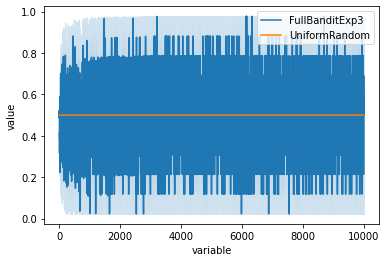

In [22]:
for name in results.keys():
    for length in results[name].keys():
        single_result = results[name][length]

        theo = theoretical_bound(int(length), single_result["sequences"][0])
        print(name, length, "regret:", np.average(single_result["regret"]), np.std(single_result["regret"]), f"({theo:.2f})")

        dataframe = pd.DataFrame(single_result["probability_array"][:, :, 0]).melt()
        sns.lineplot(data=dataframe, x="variable", y="value", label=name)



FullBanditExp3 10000 regret: 28.1 (4792.22)


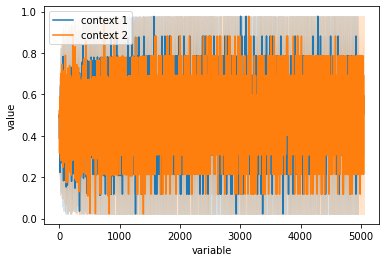

In [21]:
for name in ["FullBanditExp3"]:
    for length in results[name].keys():
        single_result = results[name][length]
        sequence = single_result["sequences"][0]

        theo = theoretical_bound(int(length), sequence)
        print(name, length, "regret:", np.average(single_result["regret"]), f"({theo:.2f})")

        data = single_result["probability_array"][:, :, 0]

        data1 = data[:, sequence.contexts[:-1, 0].astype(bool)]
        data2 = data[:, ~sequence.contexts[:-1, 0].astype(bool)]

        dataframe = pd.DataFrame(data1).melt()
        sns.lineplot(data=dataframe, x="variable", y="value", label="context 1")
        dataframe = pd.DataFrame(data2).melt()
        sns.lineplot(data=dataframe, x="variable", y="value", label="context 2")

